![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

**Elaborado por: Laura Becerra**

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

In [30]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [ ]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [ ]:
# Complementar el análisis 
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


<p align="justify"> Análisis: Se observa que verano es la estación del año en el que se presenta un mayor alquiler de bicletas con un promedio de 234, seguido por primavera (215), otoño (198) e invierno (116). Esto tiene sentido pues condiciones climáticas de mayor frio y en el caso de invierno la posibilidad de nieve desincentivarian a las personas a usar este medio de transporte. Así mismo el máximo alquiler de bicicletas (977) ocurre en verano. En todas las estaciones el mínimo de alquiler es 1. 

In [ ]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [ ]:
# Complementar el análisis 
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


<p align="justify"> Análisis: Se observa que las horas que en promedio tienen un mayor alquiler de bicicletas son las 5 y 6 de la tarde. También se observa otro pico a las 8 de la mañana. Estos horario podrían estar relacionados con las horas de ida hacia el trabajo y regreso a la casa. Así mismo, se observa que los valores mínimos de alquiler ocurren en las horas mas tarde de la noche y en la madrugada en donde la mayoria de las personas se encontrarian durmiendo o en sus lugares de residencia. 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

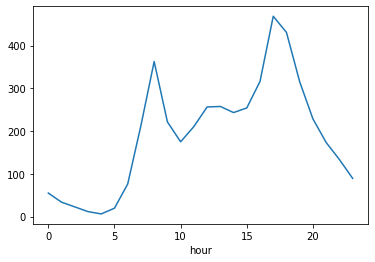

In [ ]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

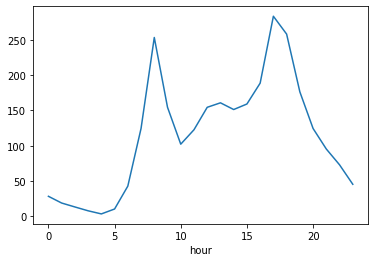

In [ ]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

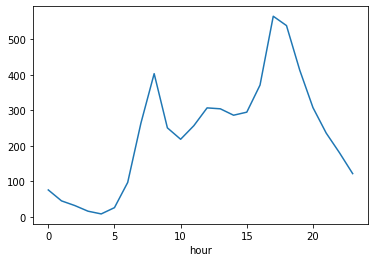

In [ ]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

<p align="justify"> Análisis: En verano los picos de alquiler de bicicletas que ocurren a las 8 y 5 de la tarde son mucho más pronunciados comparado con el total de la muestra, con cerca de 400 alquileres en promedio en el primer caso y más de 500 alquileres en promedio para el segundo. En contraste, en invierno, los picos de las 8 y 5 son muy similares y con casi la mitad de alquileres en promedio de los observados en verano. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [31]:
bikes = pd.get_dummies(bikes, columns=['season'])

In [32]:
# Celda 3
X = bikes[['season_1','season_2','season_3','hour']]
y = bikes['total'] 

# Dividir la muestra en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estimar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
print(model.coef_)

Mean Squared Error:  25592.23306921385
[-88.91820601  10.84028623  26.16013447  10.727042  ]


<p align="justify"> cuando hay cambio de estación a invierno (season1=1) el alquiler promedio de bicicletas disminuye en aproximadamente 89 unidades, cuando el cambio se da a primavera (season2=1) aumenta en cerca de 11 uniandes y en verano (season3=1) a 26 unidades, siendo el mayor aumento entre las estaciones. Es decir, el promedio de alquiler de bicicletas es menor en invierno que el alquiler de bicliceltas en el resto de estaciones. Así mismo, una hora adicional genera un aumento de cerca de 11 aquileres de bicicletas. 
<p align="justify"> Una de las desventajas de este modelo es que solo se estan usando los cambios en hora y las estaciones y hay mas variables que se podrian incluir en el modelo con información relevante que podria mejorar el poder predictivo del modelo. Así mismo, puede presentarse el problema de overfitting ya que no estamos usando tecnicas como validación cruzada para hacer diferentes particiones de la muestra. Si uno quisiera tener un modelo de predicción, valdria la pena explorar otro tipo de modelos más flexibles sacrificando la interpretabilidad. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

**Dado que tenemos un árbol de regresión debemos cambiar el gini por el MSE.**

In [35]:
# Definición de la función que calcula el MSE
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

def mse_reduction(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_reduction_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
      
    return mse_reduction_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, reduction
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            reduction = mse_reduction(X.iloc[:, j], y, split)
                        
            if reduction > best_split[2]:
                best_split = [j, split, reduction]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [36]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [37]:
def tree_predict(X, tree):
    
    predicted = np.zeros(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted + tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [39]:
y_pred = tree_predict(X_test, tree)
y_pred

array([225.82319661,  43.11842105, 507.4251497 , ..., 163.17777778,
       421.47204969,   9.1307815 ])

In [40]:
msetree = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", msetree)

Mean Squared Error:  14062.00294389704


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5
# Modelo
arbol = DecisionTreeRegressor(random_state=42)

# Parámetros
param_grid = {'max_depth': [6, 12, 18, 24],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

# Búsqueda mejor modelo
grid_search = GridSearchCV(estimator=arbol, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Mejores parámetros
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Estimar el modelo
best_regressor = grid_search.best_estimator_

# Predicción
y_pred = best_regressor.predict(X_test)

# Calcular MSE
msearbol = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", msearbol)

Best parameters:  {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.6109301888824614
Mean Squared Error:  13776.897591163506


<p align="justify"> Para este árbol de regresión se calibraron los parámetros de: Profundidad máxima del árbol, el número mínimo de observaciones que debe tener una hoja para seguir creando nuevos nodos (min_samples_split) y el número mínimo de muestras por nodo hoja (min_samples_leaf).
<p align="justify"> Con esta calibración nos damos cuenta que el mejor modelo no es el que tiene una profundida máxima de 6 si no de 12, es por esta razón que si comparamos el modelo del punto 3 con este, se obtiene un menor MSE en el segundo caso, por lo que podemos concluir que al calibrar los parámetros del modelo aumenta el poder predictivo de este.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [3]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [4]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [5]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6
# Árbol de decisión
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': [6, 12, 18, 24],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)
accuracyclf = accuracy_score(y_test, y_pred)
f1clf = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: ", accuracyclf)
print("F1-Score: ", f1clf)

# Regresión logísitca
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
accuracylr = accuracy_score(y_test, y_pred)
f1lr = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: ", accuracylr)
print("F1-Score: ", f1lr)


Best parameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.6057777777777777
Accuracy:  0.6253333333333333
F1-Score:  0.6252853729305343
Accuracy:  0.6133333333333333
F1-Score:  0.613283836832224


<p align="justify"> De acuerdo con las métricas accuracy y F1-score, el modelo de árbol de clasificación tiene un poder predictivo mayor que regresión logística. 

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [6]:
# Celda 7

# Definimos los modelos individuales
tree1 = DecisionTreeClassifier(max_depth=5, random_state=42) 
tree2 = DecisionTreeClassifier(min_samples_leaf=10, random_state=42) 
lr = LogisticRegression(random_state=42)
n_estimators = 100
model1 = BaggingClassifier(base_estimator=tree1, n_estimators=n_estimators, random_state=42, max_samples=300, bootstrap=True, n_jobs=-1, oob_score=True)
model2 = BaggingClassifier(base_estimator=tree2, n_estimators=n_estimators, random_state=42, max_samples=300, bootstrap=True, n_jobs=-1, oob_score=True)
model3 = BaggingClassifier(base_estimator=lr, n_estimators=n_estimators, random_state=42, max_samples=300, bootstrap=True, n_jobs=-1, oob_score=True)

# Entrenar el modelo en los datos de entrenamiento
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

# Evaluar el modelo en los datos de prueba
accuracy1 = accuracy_score(y_pred1, y_test)
f1score1 = f1_score(y_pred1, y_test)
accuracy2 = accuracy_score(y_pred2, y_test)
f1score2 = f1_score(y_pred2, y_test)
accuracy3 = accuracy_score(y_pred3, y_test)
f1score3 = f1_score(y_pred3, y_test)

print(accuracy1,f1score1,accuracy2,f1score2,accuracy3,f1score3)

# Crea el ensamblaje final mediante la votación mayoritaria.
ensemble = VotingClassifier(estimators=[('model1', model1), ('model2', model2), ('model3', model3)], voting='hard')

# Entrena y ajusta el ensamblaje con los datos de entrenamiento.
ensemble.fit(X_train, y_train)
y_pred4 = ensemble.predict(X_test)

# Evalúa el rendimiento del ensamblaje con los datos de prueba.
accuracy4 = accuracy_score(y_pred4, y_test)
f1score4 = f1_score(y_pred4, y_test)

print(accuracy4,f1score4)

0.6573333333333333 0.6517615176151762 0.662 0.6572008113590264 0.6206666666666667 0.6137135098438561
0.664 0.6571428571428571


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [9]:
# Obtener los errores OOB de cada modelo
errors = np.zeros(3)
errors[0] = 1 - model1.oob_score_
errors[1] = 1 - model2.oob_score_
errors[2] = 1 - model3.oob_score_
# Calcular los pesos alpha de cada modelo
alpha = (1 - errors) / sum(1 - errors)
alpha

array([0.33881502, 0.33566597, 0.32551901])

In [10]:
# Crea el ensamblaje final mediante la votación ponderada.
ensemble = VotingClassifier(estimators=[('model1', model1), ('model2', model2), ('model3', model3)], voting='soft', weights=alpha)

# Entrena y ajusta el ensamblaje con los datos de entrenamiento.
ensemble.fit(X_train, y_train)
y_pred4 = ensemble.predict(X_test)

# Evalúa el rendimiento del ensamblaje con los datos de prueba.
accuracy4 = accuracy_score(y_pred4, y_test)
f1score4 = f1_score(y_pred4, y_test)

print(accuracy4,f1score4)

0.6626666666666666 0.6617647058823529


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

<p align="justify">Tanto la votación mayoritaria como ponderada tienen un accuracy similar, mientras que el f1score es mayor en la votación ponderada, lo que refleja un mayor poder predictivo de la segunda metodologia. Dentro de las ventajas de ambas esta la posibilidad de ensamblar diferentes modelos de clasificación, de esta forma el bajo poder predictivo de un modelo puede compensarse por otros modelos. 

<p align="justify">Votación mayoritaria: una desventaja es que tener un clasificador no tan bueno bueno empeorar el comportamiento del ensamblaje. Una ventaja es que si los clasificadores base en el ensamblaje se entrenan con diferentes subconjuntos de datos o características, la votación mayoritaria puede reducir el sobreajuste y mejorar la precisión en los datos de prueba.

<p align="justify">Votación ponderada: dentro de sus desventajas esta la sensibilidad a cambios en los pesos de los modelos. Si los clasificadores en el ensamblaje tienen un sesgo similar, la asignación de pesos puede agravar este sesgo, lo que puede disminuir la precisión del modelo. De igual forma, estos pesos generan un esfuerzo computacional adicional. Sin embargo, al asignar pesos, el modelo de ensamblaje con votación ponderada puede ser más estable que el modelo de votación mayoritaria en situaciones en las que algunos clasificadores base pueden son stables.